# Page rank

## Imports

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

import networkx as nx
import graphviz as gv
import random

from typing import List

## Network classes

In [2]:
class Page:
    """A class representing a webpage."""
    def __init__(self, name):
        """Constructor method, takes the name of the webpage as an argument."""
        self.name = name
        self.outgoingLinks = []
        self.incomingLinks = []
        
    def __repr__(self):
        """A page is represented by its name."""
        return self.name
    
    def addLinkFrom(self, other):
        """Adds a link from another page, ending at this page"""
        self.incomingLinks.append(other)
    
    def addLinkTo(self, other):
        """Adds a link to another page, starting from this page"""
        self.outgoingLinks.append(other)
        other.addLinkFrom(self)
        
    def addLinksTo(self, *args):
        """Adds a link to another page, starting from this page"""
        for page in args:
            self.addLinkTo(page)
        
    def outDegree(self):
        """Returns the amount of links this page has to other pages, i.e. its out-degree"""
        return len(self.outgoingLinks)
    
    def getName(self):
        return self.name
    
    def linksTo(self, other) -> bool:
        return other in self.outgoingLinks

In [3]:
class Network:
    """A class representing a network of webpages"""
    def __init__(self):
        """A network starts without any pages."""
        self.pages = []
        self.counter = 0
        
        # Whether the dataframe is out of date
        self.old_df = True
    
    def __iter__(self):
        """Iterating over a network is the same as iterating over its pages."""
        return iter(self.pages)
        
    def addPage(self, page: Page):
        """Adds a page to the network"""
        # give the page an id (since the name of the webpage doesn't have to be unique)
        page.id = self.counter
        self.counter += 1
        self.pages.append(page)
        
        # Dataframe is out of date now
        self.old_df = True
        
    def addPages(self, *args):
        """Adds multiple pages to the network"""
        for page in args:
            self.addPage(page)
        
    def getPages(self):
        """Returns the pages in the network."""
        return self.pages
    
    def size(self):
        """Returns the size of the network."""
        return len(self.pages)
    
    def showRanking(self):
        """
        Prints the pages with their corresponding rank. 
        Not sorted on anything in particular, prints in increasing id.
        """
        for page in self:
            print(f'{page.name}: {page.rank}')
            
    def debugRanking(self):
        """
        Computes the sum of the rank of all pages in the network, which *should* return 1.
        """
        rankSum = 0
        for page in self:
            rankSum += page.rank
        print(rankSum)

    def getRankingOrder(self):
        """
        Returns a dictionary of pages with their corresponding order statistic (e.g. 1st, 2nd etc), sorted in increasing order.
        Note two pages may have the same order statistic
        """
        ranks = {page: page.rank for page in self}
        sorted_ranks = {k: v for k, v in sorted(ranks.items(), key=lambda item: item[1], reverse=True)}

        sorted_orders = {}
        
        i = 0
        previous_rank = 1
        for page in sorted_ranks:
            if sorted_ranks[page] < previous_rank:
                i += 1
            sorted_orders[page] = i
            previous_rank = sorted_ranks[page]

        return sorted_orders

    def pageInTopN(self, page: Page, n: int) -> bool:
        """
        Returns True if given page is in the top n of the network in terms of rank
        """
        sorted_orders = self.getRankingOrder()
        return sorted_orders[page] <= n
        
    def testUnconnected(self):
        """
        Prints if there are unconnected pages (pages with no link to or from them) in the network.
        """
        for page in self:
            if (len(page.incomingLinks)==0) & (len(page.outgoingLinks)==0):
                print("Page {} is unconnected".format(page.getName()))
        print("All unreported pages are connected to at least one other node via an incoming/outgoing link.")
        
    def getPage(self, name: str):
        """
        Returns page in this network with this name. 
        """
        for page in self:
            if (page.getName() == name):
                return page
        print("Error, no page with name " + name + " found!")
    
    # ----------------------------------------------------------
    # --------------------- VISUALIZATION ----------------------
    # ----------------------------------------------------------
    
    # ------------------- NODE-LINK DIAGRAMS ------------------- 
    def nxDiGraph(self):
        """Calculates networkx DiGraph"""
        # make a directed graph
        G = nx.DiGraph()
        
        # add all the edges and nodes to it
        for page in self:
            G.add_node(page)
            for other in page.outgoingLinks:
                G.add_edge(page, other)
        
        return G
    
    def plot1(self, names=False):
        """
        Plot using networkx.
        Node size based on *number of links*
        """
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by amount of links
        node_sizes = [1000 + 3000*len(page.outgoingLinks) for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
    
    def plot2(self, names=False):
        """Plot using networkx. Node size based on *rank*"""
        G = self.nxDiGraph()
        
        # calculate a layout (force-directed)
        pos = nx.layout.spring_layout(G)

        # scale nodes by rank
        node_sizes = [1000 + 3000*page.rank for page in G.nodes()]
        
        if not names:
            # labels
            labels = {page:page.id for page in G.nodes()}
            
            nx.draw(G, pos, with_labels=True, labels=labels, node_size=node_sizes, arrowsize=40, font_color="white")
        else:
            nx.draw(G, pos, with_labels=True, node_size=node_sizes, arrowsize=40, font_color="white")
        plt.show()
        
    def plot0(self):
        """Plot using graphviz"""
        f = gv.Digraph()
        for page in self:
            f.node(str(page))
            for other in page.outgoingLinks:
                f.edge(str(page), str(other))

        return f
    
    # ----------------------- STATISTICS -----------------------
    def updateDf(self):
        """Update pandas DataFrame of this network."""
        
        # Prepare a dataframe
        df = pd.DataFrame(columns=['Name', 'Outdegree', 'Indegree'])
        
        df['Name'] = list(map(Page.getName, self.pages))
        df['Outdegree'] = list(map(Page.outDegree, self.pages))
        df.fillna(0, inplace=True)
        
        # Count indegree of every page
        for page in self:
            for link in page.outgoingLinks:
                df.at[link.id, 'Indegree'] += 1
        
        # Update dataframe
        self.df = df
        self.old_df = False
        
    def plot_outdegrees(self):
        """Plots a histogram of the outdegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Outdegree'], kde=False, rug=True)
        ax.set_xlabel("Outdegree (number of links to other pages)")
        ax.set_ylabel("Frequency")
        
    def plot_indegrees(self):
        """Plots a histogram of the indegree of the pages in the network."""
        if self.old_df:
            self.updateDf()
        
        ax = sns.distplot(self.df['Indegree'], kde=False, rug=True)
        ax.set_xlabel("Indegree (number of links to this page from other pages)")
        ax.set_ylabel("Frequency")
        
    def describe(self):
        """Prints a table of summary statistics of this network."""
        if self.old_df:
            self.updateDf()
            
        return self.df.describe()
    
    def getDf(self):
        """Returns the dataframe of this network, updates it when needed."""
        if self.old_df:
            self.updateDf()
            
        return self.df
    
    def sinks(self):
        """Returns the sinks of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Outdegree'] == 0]
        
    def sources(self):
        """Returns the sources of the network."""
        if self.old_df:
            self.updateDf()
            
        return self.df[self.df['Indegree'] == 0]

### Example Wikipedia-YouTube-Twitter

In [4]:
wiki = Page("Wikipedia")
yt = Page("YouTube")
twitter = Page("Twitter")

wiki.addLinkTo(yt)
wiki.addLinkTo(twitter)
yt.addLinkTo(twitter)
twitter.addLinkTo(yt)

In [5]:
internet = Network()
internet.addPages(yt, wiki, twitter)

In [6]:
pages = internet.getPages()
pages

[YouTube, Wikipedia, Twitter]

In [7]:
yt.incomingLinks

[Wikipedia, Twitter]

In [8]:
yt.outgoingLinks

[Twitter]

### Example California Network

In [9]:
with open("california.txt") as f:
    content = f.read().splitlines()

In [10]:
california = Network()
for line in content:
    if line[0] == 'n':
        california.addPage(Page(line.split()[2]))
    elif line[0] == 'e':
        n1 = california.pages[int(line.split()[1])]
        n2 = california.pages[int(line.split()[2])]
        
        n1.addLinkTo(n2)

## Ranking the pages

In [202]:
class PageRanker:
    """A static class for ranking a network."""
    
    @staticmethod
    def rankCR(network: Network, steps: int = None, alpha: float = 0.5, epsilon: float = 1e-9, qis: List[float] = None): # rankCR = rankCertainRestart
        """
        Ranks a network via the PageRank algorithm.
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        initRanks = PageRanker.calculateInitialRanking(network)
        
        if qis == None:
            PageRanker.calculateJumpingProbabilities(network)
        else:
            for i, page in enumerate(network):
                page.q = qis[i]
        
        if steps != None:
            for _ in range(0, steps):
                PageRanker.stepRankCR(network, alpha)
        
        else:
            n = 0
            oldRanks = initRanks
            while True:
                n += 1
                newRanks = PageRanker.stepRankCR(network, alpha)
#                 print(newRanks)
                d = max([abs(newRanks[page] - oldRanks[page]) for page in network])

                if d < epsilon:
                    break
                
                oldRanks = newRanks
                    
#             print(f'Iterations: {n}')
            return n
    
    @staticmethod
    def stepRankCR(network: Network, alpha: float):
        """
        Does one step of the random-restart ranking
        """
        newRanks = {}
        for page in network:
            newRanks[page] = 0
            # Sum dot product of column and stationary distribution
            for other in network:
                if other.outDegree() > 0:
                    newRanks[page] += other.rank * page.q * (1 - alpha)
                else:
                    newRanks[page] += other.rank * page.q
                if other.linksTo(page):
                    newRanks[page] += other.rank * alpha / other.outDegree()

        for page in network:
            page.rank = newRanks[page]
            
        return newRanks
    
    @staticmethod
    def rank(network: Network, steps: int = None, alpha: float = 0.5, epsilon: float = 1e-9, qis: List[float] = None, ris: List[float] = None):
        """
        Ranks a network via the PageRank algorithm.
        Runtime O(steps * #pages * max. incoming links for a page)
        
        --- Parameters ---
        network: The Network to rank.
        steps: The number of iterations to do.
        alpha: The probability of going to another page via clicking a link.
        """
        
        if qis == None:
            PageRanker.calculateJumpingProbabilities(network)
        else:
            for i, page in enumerate(network):
                page.q = qis[i]
        
        initRanks = {}
        if ris == None:
            initRanks = PageRanker.calculateInitialRanking(network)
        else:
            for i, page in enumerate(network):
                page.rank = ris[i]
                initRanks[page] = ris[i]
        
        if steps != None:
            for _ in range(0, steps):
                PageRanker.stepRank(network, alpha)
                rankSum = sum([page.rank for page in network])
                for page in network:
                    page.rank = page.rank/rankSum
                    
                return
            
        else:
            n = 0
            oldRanks = initRanks
            
            while True:
                n += 1
                newRanks = PageRanker.stepRank(network, alpha)
                d = max([abs(newRanks[page] - oldRanks[page]) for page in network])

                if d < epsilon:
                    break
                
                oldRanks = newRanks
                    
            rankSum = sum([page.rank for page in network])
            for page in network:
                page.rank = page.rank/rankSum

#             print(f'Iterations: {n}')
            return n

        
    @staticmethod
    def stepRank(network: Network, alpha: float):
        """
        Does one step of the normalized ranking
        """
        newRanks = {}
        for page in network:
            newRanks[page] = 0
            for other in page.incomingLinks:
                newRanks[page] += other.rank / other.outDegree()
            newRanks[page] *= alpha
            newRanks[page] += (1-alpha) * page.q

        for page in network:
            page.rank = newRanks[page]
            
        return newRanks
    
    @staticmethod
    def calculateInitialRanking(network: Network):
        """
        Calculates an initial ranking for the given network.
        Currently just gives each page a ranking of 1 / size of the network.
        """
        for page in network:
            page.rank = 1.0 / network.size()
#             print("initial rank for " + str(network.size()) + " pages is " + str((1.0 / network.size())) )
            # When looking at the above print command for large networks, the sum doesn't necessarily add to 1 perfectly
            # anymore due to rounding errors
        
        return {page:1.0/network.size() for page in network}
            
    @staticmethod
    def calculateJumpingProbabilities(network: Network):
        """Calculates the probabilities of jumping to each page."""
        for page in network:
            page.q = 1.0 / network.size()


### Example Wikipedia-YouTube-Twitter Calculation

In [12]:
PageRanker.calculateInitialRanking(internet)

{YouTube: 0.3333333333333333,
 Wikipedia: 0.3333333333333333,
 Twitter: 0.3333333333333333}

#### Wikipedia-YouTube-Twitter with the Certain Restart Version

In [13]:
PageRanker.rankCR(internet)
internet.showRanking()
internet.debugRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666663
Twitter: 0.41666666666666663
0.9999999999999999


As long as the network does not have a sink, the ranks seem to be calculated correctly and still sum to 1. 

#### Wikipedia-YouTube-Twitter with Normalizer Version

In [14]:
PageRanker.rank(internet) 

2

In [15]:
internet.showRanking()

YouTube: 0.41666666666666663
Wikipedia: 0.16666666666666666
Twitter: 0.41666666666666663


In [16]:
internet.debugRanking() # This one is the one with the normalizer feature, naturally it sums perfectly to 1 for this simple network

0.9999999999999999


### Example California Network Calculation

#### Certain Restart Version

In [17]:
# slow (this is only 1 iteration!)
# PageRanker.rankCR(california, 1, 0.5)
# california.showRanking()
# california.debugRanking()

#### Normalizer Version

In [18]:
PageRanker.rank(california)
california.showRanking()
california.debugRanking()

http://www.berkeley.edu/: 0.0014796631968201919
http://www.caltech.edu/: 0.00042677764977363115
http://www.realestatenet.com/: 6.973437949899235e-05
http://www.ucsb.edu/: 0.0007300449721356065
http://www.washingtonpost.com/wp-srv/national/longterm/50states/ca.htm: 7.760761589403974e-05
http://www-ucpress.berkeley.edu/: 0.00016991007769839912
http://www.ucr.edu/: 0.0003377886496539933
http://www.tegnetcorporation.com/: 5.173841059602649e-05
http://www.research.digital.com/SRC/virtual-tourist/California.html: 0.0006790729266729559
http://www.leginfo.ca.gov/calaw.html: 0.001057112928319848
http://www.csun.edu/: 0.00028766475264429425
http://www.calpoly.edu/: 0.00020652805716495217
http://www.calbar.org/: 0.00031850516012709676
http://ideas.uqam.ca/ideas/data/fthcalaec.html: 5.173841059602649e-05
http://www.sen.ca.gov/: 0.0006930088161040139
http://www.csupomona.edu/: 0.00024010624197873823
http://www.csuchico.edu/: 0.00018335040967153938
http://www.calacademy.org/: 0.0007159022632606338
h

http://www.zebu.uoregon.edu/AB.html: 5.173841059602649e-05
http://www.vwc.edu/wwwpages/gnoe/avd.htm: 0.00010748038867865027
http://www.csun.edu/~vceed009/ideas.html: 5.173841059602649e-05
http://www.mes.umn.edu/~hoefer/extnsion/bookmark/otherlst/sustagri.htm: 5.173841059602649e-05
http://www.brincad.com/brincad/BT_ENV.HTM: 5.173841059602649e-05
http://www.eecs.umich.edu/mathscience/funexperiments/agesubject/lessons/energy/lightning.html: 5.173841059602649e-05
http://www.nceet.snre.umich.edu/activities.html: 5.173841059602649e-05
http://sln.fi.edu/inquirer/hydrocar.html/inquirer.html: 5.173841059602649e-05
http://www.igc.org/igc/issues/energy/or.html: 5.173841059602649e-05
http://www.energyonline.com/Restructuring/forum/frmhome.html: 5.173841059602649e-05
http://www.doi.gov/pam/pmemtb3.html: 5.173841059602649e-05
http://grove.ufl.edu/~lac/flag/resources.html: 5.173841059602649e-05
http://www.npr.org/programs/sfkids/showarchive/sfkc.96.01.19.html: 5.173841059602649e-05
http://www.fi.edu/

http://pcfit.ucdavis.edu/: 5.173841059602649e-05
http://staff.ucdmc.ucdavis.edu/: 5.173841059602649e-05
http://www.unm.edu/~dave/policy.html: 5.173841059602649e-05
http://wwwcsif.cs.ucdavis.edu/~rimer/surf.html: 5.173841059602649e-05
http://environment.ucdavis.edu/: 5.173841059602649e-05
http://www-seafood.ucdavis.edu/listserv/Listserv.htm: 5.173841059602649e-05
http://www.unh.edu/Campus/cis/NIS/Policy/web-policies.html: 5.173841059602649e-05
http://cause-www.colorado.edu/information-resources/ir-library/abstracts/url0031.html: 5.173841059602649e-05
http://www.law.miami.edu/AOK/aok4use.html: 5.173841059602649e-05
http://teamwork.ucdavis.edu/teamwork: 5.173841059602649e-05
http://www.physics.ucdavis.edu/: 5.173841059602649e-05
http://www.ucop.edu/irc/policy: 7.497516100947843e-05
http://hr.ucdavis.edu/saad/document.htm#PRINCIPLES: 7.497516100947843e-05
http://www.mrak.ucdavis.edu/web-mans/ppm/210/210-70.htm: 7.497516100947843e-05
http://www.mrak.ucdavis.edu/web-mans/ppm/280/280-05.htm: 

http://id-www.ucsb.edu/detche/library/calhed/priv.html: 5.173841059602649e-05
http://columbia.digiweb.com/~michaelh/: 5.173841059602649e-05
http://www.lid.com/LIDlinks/l_general_info.html: 5.173841059602649e-05
http://sanfrancisco.thelinks.com/: 5.173841059602649e-05
http://www.heimat.org/ccac4.html: 5.173841059602649e-05
http://gen.com/ani/hotmks1.htm: 5.173841059602649e-05
http://www.yahoo.com/Regional/U_S__States/Nevada/Science/index.html: 5.173841059602649e-05
http://www.wyrdsci.com/links/linksn.htm: 5.173841059602649e-05
http://www.starlighter.com/are/: 5.173841059602649e-05
http://www.yahoo.co.uk/Regional/U_S__States/Nevada/Science/: 5.173841059602649e-05
http://www.are-cayce.com/: 9.700951986754968e-05
http://www.ccnet.com/~rwilkins/: 6.790666390728476e-05
http://www.datasync.com/~kc5pza/links.html: 5.173841059602649e-05
http://www.cs.purdue.edu/finger/ccnet3.ccnet.com/rwilkins: 5.173841059602649e-05
http://www.west.net/~sbarb/links.htm: 5.173841059602649e-05
http://www.hom.net/

http://www.wsu.edu:8080/~geology/geol101/rivers/rivers_links.html: 5.173841059602649e-05
http://www.lisp.com.au/megaweb/html/6500b_e8.htm: 5.173841059602649e-05
http://www.co.sacramento.ca.us/emergenc.ops/index.html: 5.543401135288552e-05
http://www.disasterrelief.org/Disasters/970114floods/: 5.173841059602649e-05
http://pages.prodigy.com/waite/: 5.173841059602649e-05
http://gilligan.uafadm.alaska.edu/eswsl/disaster.cfm: 5.173841059602649e-05
http://www.wlu.edu/~omcguire/earthx.html: 5.173841059602649e-05
http://socalink.com/Reviews/Science/Planet_Earth/Resources/index.latimes.html: 5.173841059602649e-05
http://www.themall.net/links/index.html: 5.173841059602649e-05
http://truckeetahoe.com/: 5.173841059602649e-05
http://home.sprynet.com/sprynet/keithco/cube-trw.htm: 5.173841059602649e-05
http://eci2.ucsb.edu/~tbmaddux/h_noframe.html: 5.173841059602649e-05
http://www-ccs.ucsd.edu/oilspill/: 5.82057119205298e-05
http://www.real-surfing.com/weather/southern_california.html: 5.173841059602

### Edge Case: Source -> Sink

#### Normalizer Version

In [19]:
criminal = Network()
page1 = Page("Source")
page2 = Page("Sink")
page1.addLinkTo(page2)
criminal.addPages(page1, page2)

In [20]:
#criminal.plot0()

In [21]:
PageRanker.rank(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

Source: 0.4
Sink: 0.6
1.0


In [22]:
nx.pagerank(criminal.nxDiGraph(), alpha=0.5, max_iter=10)

{Source: 0.40000009536743164, Sink: 0.5999999046325684}

#### Certain Restart Version

In [23]:
PageRanker.rankCR(criminal, 10, 0.5)
criminal.showRanking()
criminal.debugRanking()

Source: 0.40000009536743164
Sink: 0.5999999046325684
1.0


### Timo's handsolved network

In [24]:
handsolved = Network()
w1 = Page("Website 1")
w2 = Page("Website 2")
w3 = Page("Website 3")
w4 = Page("Website 4")
w5 = Page("Website 5")

w1.addLinksTo(w2, w3, w4, w5)
w2.addLinksTo(w3, w4, w5)
w3.addLinksTo(w1, w2, w4, w5)
w4.addLinksTo(w2, w3)
w5.addLinkTo(w4)

handsolved.addPages(w1, w2, w3, w4, w5)
#handsolved.plot0()

In [25]:
PageRanker.rankCR(handsolved, 100, 0.5)
handsolved.showRanking()

Website 1: 0.12720848056537118
Website 2: 0.20989399293286243
Website 3: 0.21766784452296845
Website 4: 0.2671378091872795
Website 5: 0.17809187279151964


In [26]:
print(f'Website 1: {36/283}')
print(f'Website 2: {297/1415}')
print(f'Website 3: {308/1415}')
print(f'Website 4: {378/1415}')
print(f'Website 5: {252/1415}')

Website 1: 0.127208480565371
Website 2: 0.20989399293286218
Website 3: 0.2176678445229682
Website 4: 0.26713780918727914
Website 5: 0.17809187279151945


## Visualization of (small) networks

### With networkx

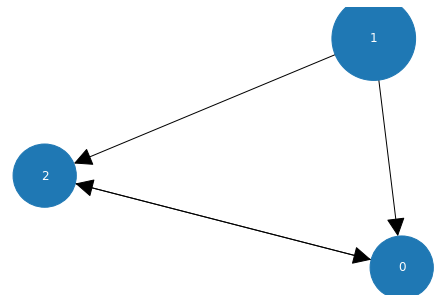

In [27]:
# size based on links
internet.plot1()

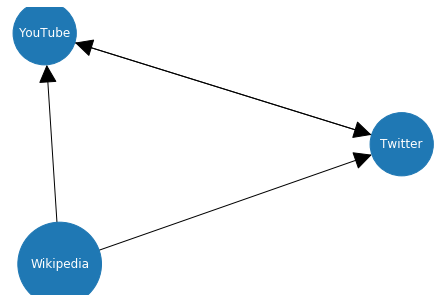

In [28]:
# plot with names (works in this case, but often labels are too large for the nodes)
internet.plot1(names=True)

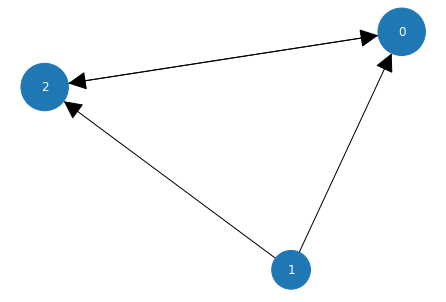

In [29]:
#size based on rank
internet.plot2()

### With graphviz

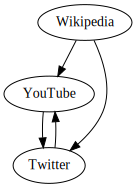

In [30]:
internet.plot0()

### Homepage Network

In [31]:
def makeHomepageNetwork(sinkSiteAmount: int = 100):
    homepageNetwork= Network()
    homepage = Page("Homepage")
    for i in range(0,sinkSiteAmount):
        p = Page("test" + str(i))
        homepage.addLinkTo(p)
        homepageNetwork.addPage(p)
    homepageNetwork.addPage(homepage)
    return homepageNetwork

### Endpage Network

In [32]:
# Configurable parameter
def makeEndpageNetwork(sourceSiteAmount: int = 100):
    endpageNetwork = Network()
    endpage = Page("Endpage")
    for i in range(0,sourceSiteAmount):
        p = Page("test" + str(i))
        p.addLinkTo(endpage)
        endpageNetwork.addPage(p)
    endpageNetwork.addPage(endpage)
    return endpageNetwork

## Statistics

In [33]:
internet.sources()

,Name,Outdegree,Indegree
1,Wikipedia,2,0


In [34]:
internet.sinks()

,Name,Outdegree,Indegree


In [35]:
california.sinks()

,Name,Outdegree,Indegree
9,http://www.leginfo.ca.gov/calaw.html,0,155
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
15,http://www.csupomona.edu/,0,36
16,http://www.csuchico.edu/,0,32
33,http://www.ftb.ca.gov/,0,46
...,...,...,...
9655,http://www.fleamarket.net/,0,0
9658,http://remco.com/fun.html,0,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0


In [36]:
california.sources()

,Name,Outdegree,Indegree
7,http://www.tegnetcorporation.com/,11,0
13,http://ideas.uqam.ca/ideas/data/fthcalaec.html,0,0
79,http://www.mapquest.com/wine/mqinterconnect,1,0
95,http://www.angelfire.com/ca/srcom/index.html,4,0
120,http://www.psn.net/support/access_num.phtml,2,0
...,...,...,...
9659,http://www.spd.louisville.edu/~mejenn01/handy....,1,0
9660,http://www.maxwellstreet.org/,0,0
9661,http://village.ios.com/~internet/,0,0
9662,http://www.meats.net/,0,0


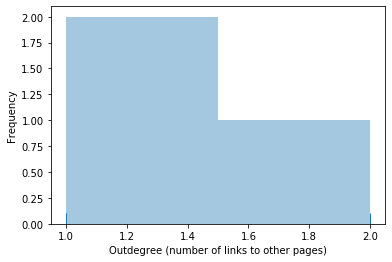

In [37]:
internet.plot_outdegrees()

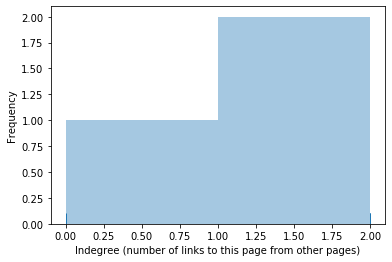

In [38]:
internet.plot_indegrees()

In [39]:
internet.describe()

,Outdegree,Indegree
count,3.000000,3.000000
mean,1.333333,1.333333
std,0.577350,1.154701
min,1.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,2.000000
75%,1.500000,2.000000
max,2.000000,2.000000


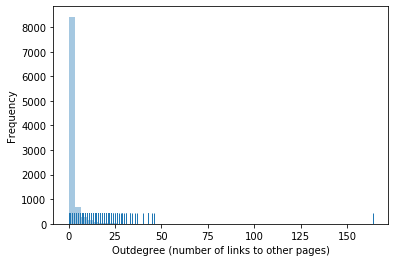

In [40]:
california.plot_outdegrees()

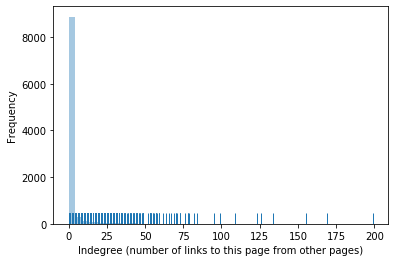

In [41]:
california.plot_indegrees()

In [42]:
california.describe()

,Outdegree,Indegree
count,9664.000000,9664.000000
mean,1.671151,1.671151
std,3.695696,7.457138
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,0.000000
max,164.000000,199.000000


# More Network Generators

In [43]:
def makeClusterNetwork(clusterAmount: int=3, clusterSize: int=10, forwardLinkClusters: bool=True, backwardLinkClusters: bool=True):
    """
    --- Parameters ---
    clusterAmount: Amount of clusters in the network.
    clusterSize: Amount of pages per cluster.
    forwardLinkClusters: Should there exist a link from cluster i to i+1 for all i?
    backwardLinkClusters: Should there exist a link from cluster i to i-1 for all i?
    """
    currentCluster = []
    clusterNetwork = Network()
    for i in range(0, clusterAmount):
        for j in range(0, clusterSize):
            p = Page("cluster_" + str(i) + "_site_" + str(j))
            clusterNetwork.addPage(p)
            for otherPage in currentCluster:
                p.addLinkTo(otherPage)
                otherPage.addLinkTo(p)
            currentCluster.append(p)    
        currentCluster = []
    
    if forwardLinkClusters:
        for i in range(0, clusterAmount):
            if (i==clusterAmount - 1):
                nextClusterID = 0
            else:
                nextClusterID = i + 1
            clusterNetwork.getPage("cluster_" + str(i) + "_site_0").addLinkTo(clusterNetwork.getPage("cluster_" + str(nextClusterID) + "_site_0"))

    if backwardLinkClusters:
        for i in range(0, clusterAmount):
            if (i==0):
                previousClusterID = clusterAmount - 1
            else:
                previousClusterID = i - 1
            clusterNetwork.getPage("cluster_" + str(i) + "_site_0").addLinkTo(clusterNetwork.getPage("cluster_" + str(previousClusterID) + "_site_0"))

    return clusterNetwork

In [44]:
# Fully linked network where every site has a link to every other site except for the last sinkAmount (parameter) sites.
# The last site is a sink and only has incoming links.
def makeNetworkSinks(sinkAmount: int = 3, networkSize: int = 10):
    """
    --- Parameters ---
    sinkAmount: Amount of pages in the network without outgoing links.
    networkSize: Amount of pages in the network
    Beware, the function requires sinkAmount <= networkSize!
    """
    networkSinks = Network()
    for i in range(0, networkSize):
        p = Page("site_" + str(i))
        networkSinks.addPage(p)
    for page in networkSinks:
        pageID = int(page.getName()[5:])
        # if not one of the sinks
        if pageID >= sinkAmount:
            # then create links to all other pages which are not itself
            for otherPage in networkSinks:
                otherPageID = int(otherPage.getName()[5:])
                if not(otherPageID == pageID):
                    page.addLinkTo(otherPage)
    return networkSinks

In [149]:
# Every site points to the next in a big "circle"

# Configurable Parameter
circleSize = 50
# Only forward-pointing links or also backward-pointing links?
twoWay = True
def makeNetworkCircle(circleSize: int = 50, twoWay: bool = True):
    """
    --- Parameters ---
    circleSize: Amount of pages in the circular network.
    twoWay: Boolean representing if there are only forward-pointing links or also backward-pointing links,
    so if the "circle" is traversable in two directions or in 1 direction.
    """
    networkCircle = Network()
    for i in range(0, circleSize):
        p = Page("site_" + str(i))
        networkCircle.addPage(p)
    for page in networkCircle:
        pageID = int(page.getName()[5:])
        if not(pageID == circleSize - 1):
            nextPageID = pageID + 1
        else:
            nextPageID = 0
        page.addLinkTo(networkCircle.getPage("site_" + str(nextPageID)))
        if twoWay:
            if not(pageID == 0):
                previousPageID = pageID - 1
            else:
                previousPageID = circleSize - 1
            page.addLinkTo(networkCircle.getPage("site_" + str(previousPageID)))
    return networkCircle


# The Random "Spatial" Network

This random network of websites is supposed to reflect the spatial nature of the internet. For example, Chinese websites will probably have a lot of links to other Chinese websites and similarly for for example Spanish websites. However, between the two subnetworks (or clusters), there will probably be a lot fewer links. This example network is supposed to reflect that.

In [46]:
class SpatialPage(Page):
    def __init__(self, name, x, y):
        super().__init__(name)
        self.x = x
        self.y = y
        
    def squaredDistanceTo(self, other):
        return (self.x-other.x)^2 + (self.y-other.y)^2

In [47]:
def makeSpatialNetwork(n, xmax, ymax, r):
    """
    Returns a spatial network
    === Parameters ===
    n: amount of pages
    xmax: largest x coordinate
    ymax: largest y coordinate
    r: range which determines whether cells are neighbours
    """
    spatialNetwork = Network()
    
    for i in range(n):
        x = round(xmax * random.random())
        y = round(ymax * random.random())
        
        p = SpatialPage(f'Page {i}', x, y)
        spatialNetwork.addPage(p)
    
    for page in spatialNetwork:
        for other in spatialNetwork:
            if page == other:
                continue
            
            d = page.squaredDistanceTo(other)
            if d <= r^2:
                # maybe do this with a link probability?
                page.addLinkTo(other)
    
    return spatialNetwork

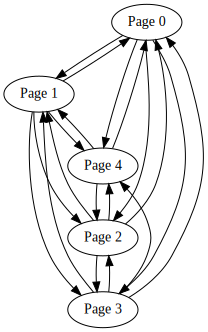

In [48]:
test = makeSpatialNetwork(5, 10, 10, 2)
test.plot0()

In [49]:
# Configurable parameters
siteAmount = 100
# Coordinate range
xmax = 10
ymax = 10
# "Closeness" bound. If sites are within this range of each other, they will link to each other.
closeRange = 5

# Constants
spatialNetwork= Network()
df_coords = pd.DataFrame(columns = ["x", "y"])
adjust = max(xmax,ymax) // 10 + 1
closeRangeSqr = closeRange*closeRange

for i in range(0,siteAmount):
    # Determine random integer coordinates between 0 and 100 for all sites
    x = round(xmax * random.random())
    y = round(ymax * random.random())
    
    
    df_coords.loc[i] = [x, y]
    # Keep this information in the "name" string of the website. 
    # Add the filler character "f" such that the coordinates fill up 3 characters

    p = Page("{}".format(x).rjust(adjust, "f") + "_" + "{}".format(y).rjust(adjust, "f"))
    spatialNetwork.addPage(p)
    #print("Adding site " + p.getName())
    
    for other in spatialNetwork:
        # Take slices of the other's name and strip zeros accordingly to het back the coordinates
        otherName = other.getName()
        otherX = otherName[:adjust].lstrip("f")
        otherY = otherName[adjust+1:].lstrip("f")
        #print("Other site found with X = " + otherX + " and Y = " + otherY)
        
        # If the other site and site p are close enough (and other =/= p !!)
        distance = (int(otherX)-x)*(int(otherX)-x) + (int(otherY)-y)*(int(otherY)-y)
        if (distance <= closeRangeSqr)&(0<distance):
            other.addLinkTo(p)
            p.addLinkTo(other)

In [50]:
PageRanker.rankCR(spatialNetwork, 1000, 0.5)
spatialNetwork.showRanking()
spatialNetwork.debugRanking()

f9_f9: 0.007908008462573392
f1_f5: 0.009797975912709946
f4_f6: 0.012416250958951859
10_f7: 0.008867044954962813
f7_f5: 0.012240951677755161
f8_f1: 0.008640516071334694
10_f2: 0.0080263508869708
10_f9: 0.008042775194261042
f4_f5: 0.012638046556288739
10_f1: 0.007747397865480597
f7_f4: 0.01143935465979118
f8_f4: 0.010755592474537373
f7_f5: 0.012240951677755161
f7_f1: 0.009601208618768127
f2_f1: 0.008606257923755333
f1_f2: 0.008459263875060498
f8_f3: 0.010375213220248428
f9_f9: 0.007908008462573392
f9_f9: 0.007908008462573392
f6_f2: 0.010697749436824071
f3_f8: 0.009922778970778536
f7_f5: 0.012240951677755161
f5_f4: 0.012754361889402929
f2_f3: 0.009666362332011477
f7_f0: 0.008633601128772043
f3_f4: 0.011060779023079507
f3_f6: 0.011309195129491256
f2_f7: 0.009526137123610386
f6_f1: 0.010020133730743144
f5_f9: 0.010362063860581593
f8_10: 0.008173244356286913
f1_f9: 0.008092906244136264
f4_f3: 0.011363420509189887
f7_f5: 0.012240951677755161
f9_f2: 0.008457955214833989
f4_f4: 0.01199472209407

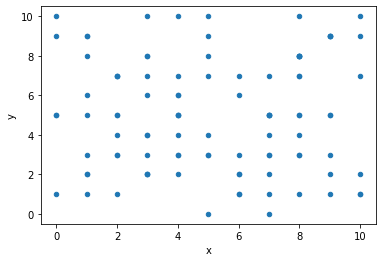

In [51]:
df_coords.plot(kind="scatter", x="x", y="y");

In [52]:
# spatialNetwork.plot2()

In [53]:
spatialNetwork.testUnconnected()

All unreported pages are connected to at least one other node via an incoming/outgoing link.


In [54]:
PageRanker.rank(spatialNetwork)

11

## Completely Random Network

In [55]:
def makeRandomNetwork(n: int = 100, successProbability: float = 0.1):
    randomNetwork= Network()

    for i in range(0,n):
        p = Page("Page {}".format(i))
        randomNetwork.addPage(p)

    for p in randomNetwork:
        for other in randomNetwork:
            # Check if equal
            if not(other.getName() == p.getName()):
                if (random.random() < successProbability):
                    other.addLinkTo(p)
                    
    return randomNetwork

In [56]:
randomNetwork = makeRandomNetwork()

In [57]:
PageRanker.rankCR(randomNetwork, 100, 0.5)
randomNetwork.showRanking()
randomNetwork.debugRanking()

Page 0: 0.011200334342755254
Page 1: 0.010192934549988774
Page 2: 0.007497250260277697
Page 3: 0.008302660074370503
Page 4: 0.010925666216497867
Page 5: 0.010386203925222383
Page 6: 0.010131532924206208
Page 7: 0.007251666447945297
Page 8: 0.011162977757607762
Page 9: 0.009480483815168663
Page 10: 0.014240354278916569
Page 11: 0.008136048470713734
Page 12: 0.01117024901827826
Page 13: 0.00903908211281436
Page 14: 0.007875105164496127
Page 15: 0.013057958965652459
Page 16: 0.009965247282793457
Page 17: 0.01059708395071362
Page 18: 0.009091591362517476
Page 19: 0.00828524090238054
Page 20: 0.009745318519807892
Page 21: 0.01061076713443074
Page 22: 0.011173172510138262
Page 23: 0.009800270687033026
Page 24: 0.012312306162087769
Page 25: 0.007268601353915124
Page 26: 0.01224919240278595
Page 27: 0.011116239705083776
Page 28: 0.007884218292867094
Page 29: 0.008598767289171784
Page 30: 0.01246888184002525
Page 31: 0.008418314908509908
Page 32: 0.011420479070510156
Page 33: 0.0114643227360369

In [58]:
PageRanker.rank(randomNetwork, 1000, 0.5)
randomNetwork.showRanking()
randomNetwork.debugRanking()

Page 0: 0.011200334342755127
Page 1: 0.010192934549988658
Page 2: 0.007497250260277612
Page 3: 0.008302660074370407
Page 4: 0.010925666216497746
Page 5: 0.010386203925222267
Page 6: 0.010131532924206094
Page 7: 0.0072516664479452125
Page 8: 0.011162977757607634
Page 9: 0.009480483815168554
Page 10: 0.014240354278916411
Page 11: 0.008136048470713642
Page 12: 0.011170249018278134
Page 13: 0.009039082112814258
Page 14: 0.007875105164496037
Page 15: 0.013057958965652313
Page 16: 0.009965247282793346
Page 17: 0.0105970839507135
Page 18: 0.009091591362517372
Page 19: 0.008285240902380444
Page 20: 0.00974531851980778
Page 21: 0.010610767134430621
Page 22: 0.01117317251013814
Page 23: 0.009800270687032915
Page 24: 0.012312306162087632
Page 25: 0.007268601353915041
Page 26: 0.01224919240278581
Page 27: 0.011116239705083653
Page 28: 0.007884218292867002
Page 29: 0.008598767289171687
Page 30: 0.012468881840025106
Page 31: 0.008418314908509814
Page 32: 0.011420479070510027
Page 33: 0.0114643227360

In [59]:
# randomNetwork.plot2()
# randomNetwork.testUnconnected()

In [60]:
PageRanker.rank(randomNetwork)

10

In [160]:
iterations = {}
n = 1000
# n=1
nNodes = 500
for i in range(n):
    p = i/n
    net = makeRandomNetwork(nNodes, p)
    iterations[p] = PageRanker.rank(net)

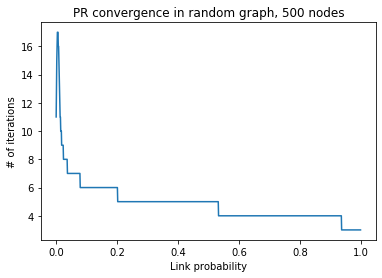

In [161]:
from scipy.ndimage.filters import gaussian_filter1d
x = list(iterations.keys())
y = list(iterations.values())

fig, ax = plt.subplots(1, 1)
# ax.plot(x, y)
ax.plot(x, gaussian_filter1d(y, sigma=2))
ax.set_xlabel("Link probability")
ax.set_ylabel("# of iterations")
ax.set_title(f'PR convergence in random graph, {nNodes} nodes');

In [63]:
# ax.get_figure().savefig("plot.pdf")

## 2WB20 Canvas Page

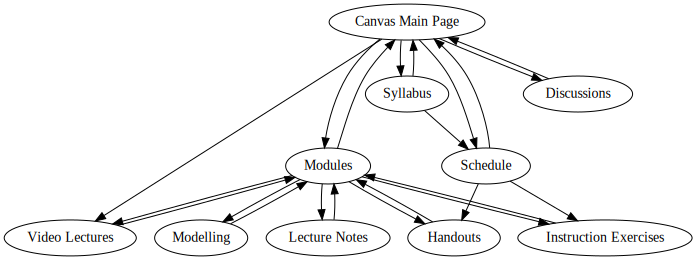

In [64]:
canvas = Network()
w1 = Page("Canvas Main Page")
w2 = Page("Modules")
w3 = Page("Schedule")
w4 = Page("Syllabus")
w5 = Page("Discussions")
w6 = Page("Video Lectures")
w7 = Page("Lecture Notes")
w8 = Page("Instruction Exercises")
w9 = Page("Modelling")
w10 = Page("Handouts")

w1.addLinksTo(w2, w3, w4, w5, w6)
w2.addLinksTo(w1, w6, w7, w8, w9, w10)
w3.addLinksTo(w1, w8, w10)
w4.addLinksTo(w1, w3)
w5.addLinkTo(w1)
w6.addLinkTo(w2)
w7.addLinkTo(w2)
w8.addLinkTo(w2)
w9.addLinkTo(w2)
w10.addLinkTo(w2)

canvas.addPages(w1, w2, w3, w4, w5, w6, w7, w8, w9, w10)
canvas.plot0()

In [65]:
PageRanker.rank(canvas)
canvas.showRanking()

Canvas Main Page: 0.13251670385550707
Modules: 0.26280623584636176
Schedule: 0.07906458796639339
Syllabus: 0.06325167036356727
Discussions: 0.06325167036356727
Video Lectures: 0.08515219007922678
Lecture Notes: 0.07190051971565951
Instruction Exercises: 0.08507795104702875
Modelling: 0.07190051971565951
Handouts: 0.08507795104702875


In [66]:
personalization = [0.7, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9, 0.3/9]

In [67]:
PageRanker.rank(canvas, qis=personalization)
canvas.showRanking()

Canvas Main Page: 0.4203167533663985
Modules: 0.16877010611412083
Schedule: 0.07337292748450815
Syllabus: 0.058698341975553556
Discussions: 0.058698341975553556
Video Lectures: 0.07276251756307878
Lecture Notes: 0.030730842254191898
Instruction Exercises: 0.042959663506201395
Modelling: 0.030730842254191898
Handouts: 0.042959663506201395


In [68]:
canvas.getRankingOrder()

{Canvas Main Page: 1,
 Modules: 2,
 Schedule: 3,
 Video Lectures: 4,
 Syllabus: 5,
 Discussions: 5,
 Instruction Exercises: 6,
 Handouts: 6,
 Lecture Notes: 7,
 Modelling: 7}

In [69]:
# Canvas main page in top 5
canvas.pageInTopN(w1, 5)

True

In [70]:
# Handouts page not in top 5
canvas.pageInTopN(w10, 5)

False

## Testing Area

In [71]:
list_of_results = []
for i in range(0,10):
    net = makeEndpageNetwork((i+1) * 1000)
    list_of_results.append(PageRanker.rank(net))
print(list_of_results)


[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


In [72]:
network = makeHomepageNetwork(1000)
PageRanker.rank(network, 1000, 0.5)
network.showRanking()

test0: 0.000999001497753381
test1: 0.000999001497753381
test2: 0.000999001497753381
test3: 0.000999001497753381
test4: 0.000999001497753381
test5: 0.000999001497753381
test6: 0.000999001497753381
test7: 0.000999001497753381
test8: 0.000999001497753381
test9: 0.000999001497753381
test10: 0.000999001497753381
test11: 0.000999001497753381
test12: 0.000999001497753381
test13: 0.000999001497753381
test14: 0.000999001497753381
test15: 0.000999001497753381
test16: 0.000999001497753381
test17: 0.000999001497753381
test18: 0.000999001497753381
test19: 0.000999001497753381
test20: 0.000999001497753381
test21: 0.000999001497753381
test22: 0.000999001497753381
test23: 0.000999001497753381
test24: 0.000999001497753381
test25: 0.000999001497753381
test26: 0.000999001497753381
test27: 0.000999001497753381
test28: 0.000999001497753381
test29: 0.000999001497753381
test30: 0.000999001497753381
test31: 0.000999001497753381
test32: 0.000999001497753381
test33: 0.000999001497753381
test34: 0.00099900149775

In [73]:
1/1001

0.000999000999000999

In [194]:
n = 100
rs = [1] + (n-1)*[0]

In [199]:
circle = makeNetworkCircle(n, True)

In [200]:
# circle.plot0()

In [203]:
PageRanker.rank(circle, ris=rs)

29

In [208]:
PageRanker.rank(makeRandomNetwork(100, 0.015))

19